In [1]:
%matplotlib notebook
import cmath
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')

from indra.common import Circle, Line
from indra.mobius import MobiusTransformation as Mobius
from indra.plotting.tiles import plot_tiles
from indra.plotting.limit import plot_limit_set
from indra.recipes import kissing_schottky

In [2]:
gens, circs = kissing_schottky(1.5, 0.2)

<IPython.core.display.Javascript object>


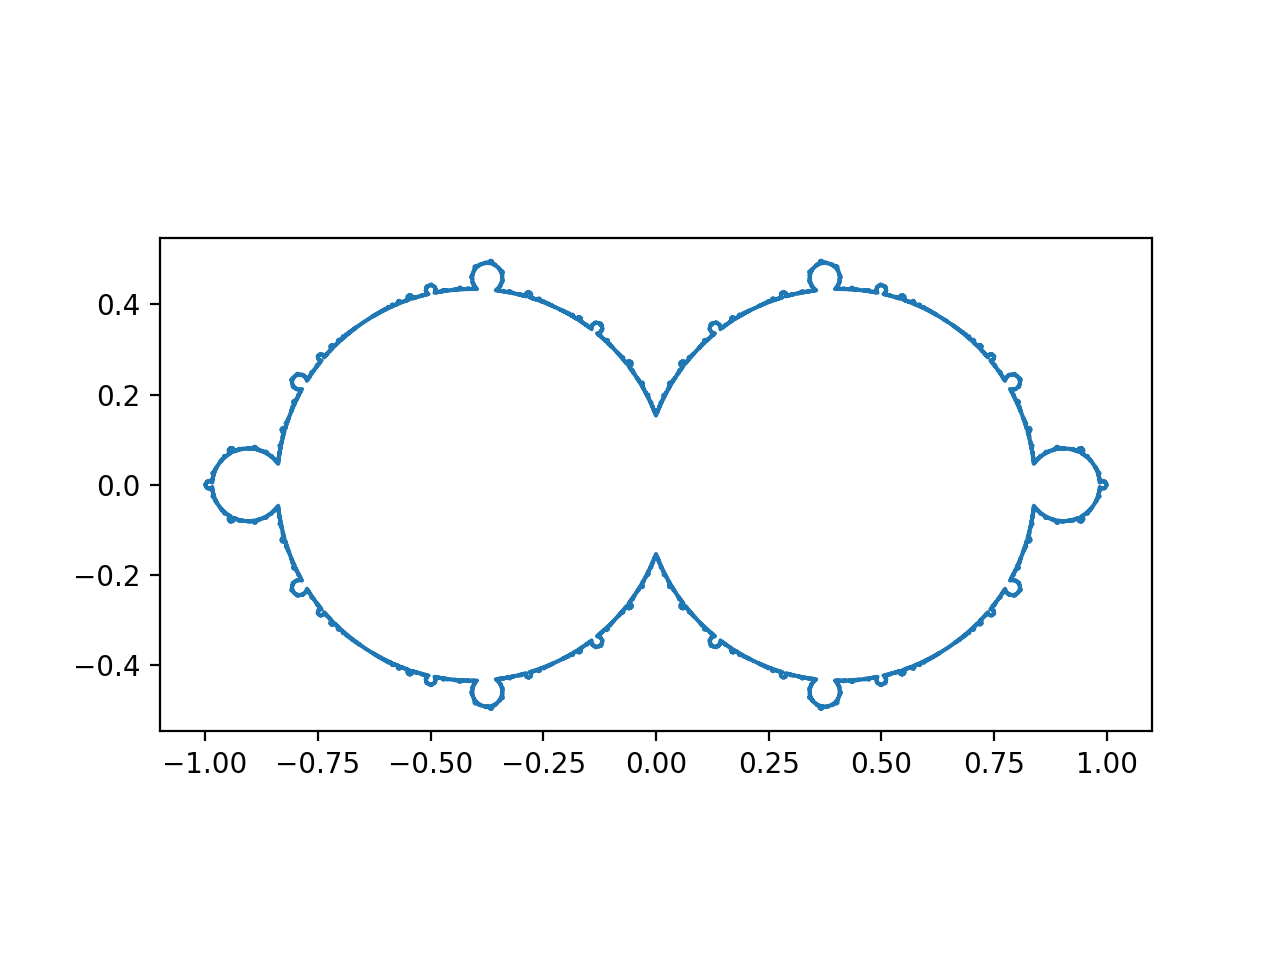

In [3]:
plot_limit_set(gens)

<IPython.core.display.Javascript object>


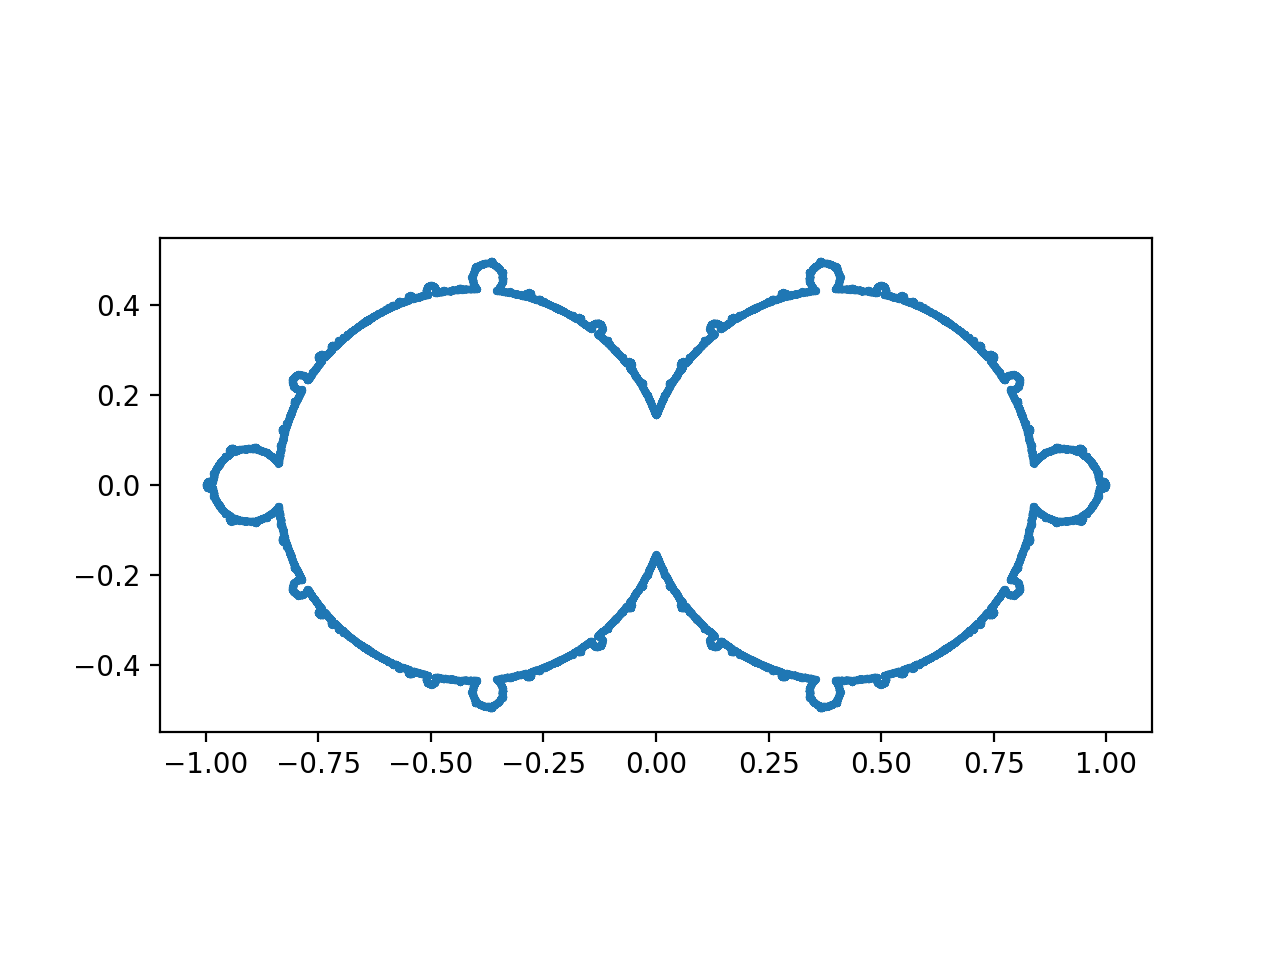

In [5]:
plot_limit_set(gens, as_curve=False, eps=1e-3)

<IPython.core.display.Javascript object>


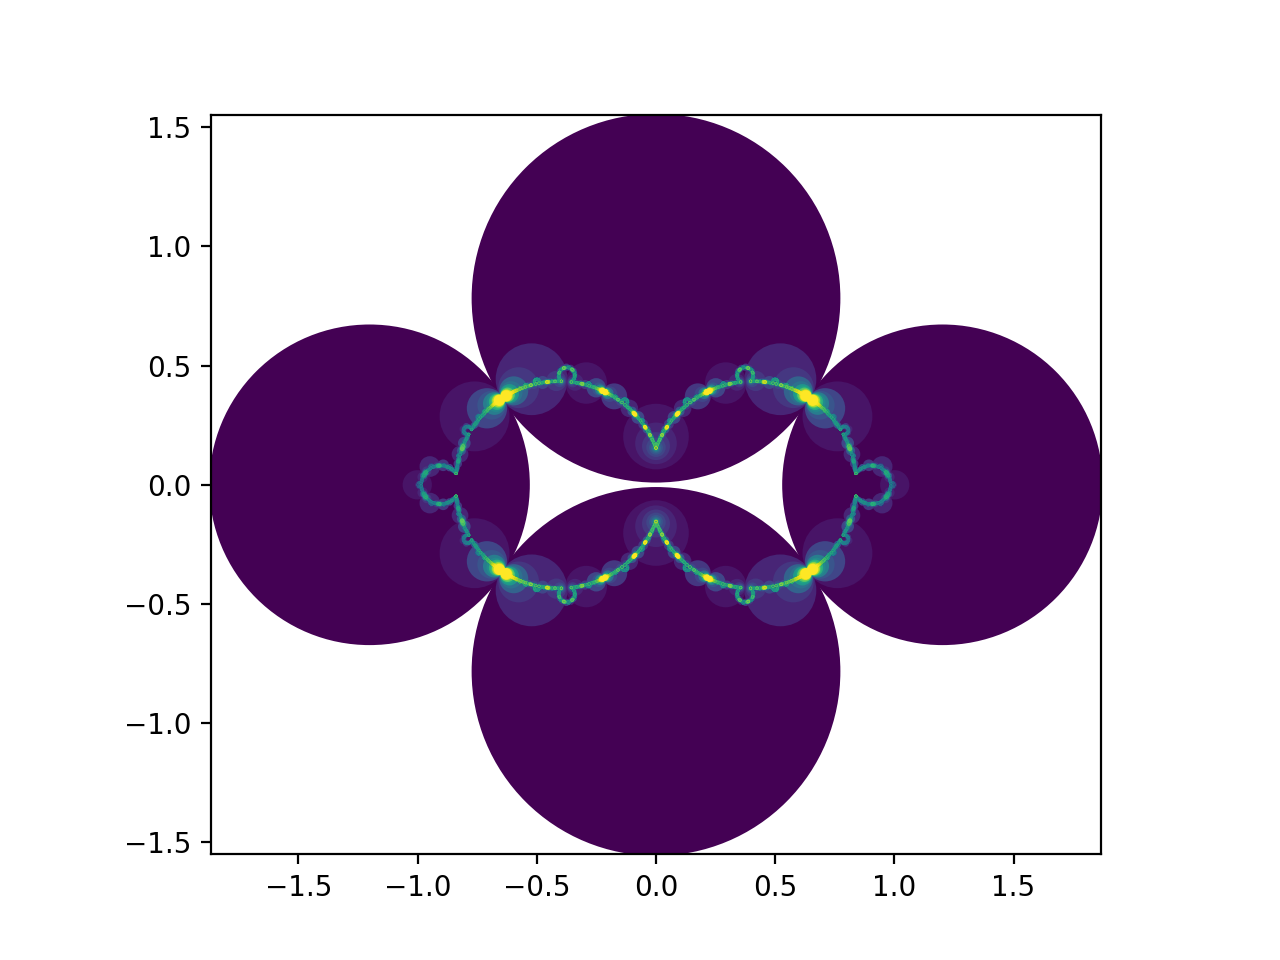

In [7]:
plot_tiles(gens, circs)

## Plotting stretches of limit set

In [28]:
from indra.plotting.limit import *
from indra.common import tags_to_word, word_to_fct, tags_to_fct, word_to_tags
from indra.recipes import parabolic_commutator

import itertools

In [34]:
gens = parabolic_commutator(1.91+0.05j, 1.91+0.05j)

In [47]:
def starts_with(tags, prefix_tags):
    """Check whether tags starts with a given prefix"""
    return list(itertools.islice(tags, 0, len(prefix_tags))) == prefix_tags


def all_lefts_from(tags, idx):
    """Check whether tags is all left turns starting from idx"""
    for i in range(idx, len(tags)-1):
        if left_of(tags[i]) != tags[i+1]:
            return False
    return True


def precedes_or_equal(tags_1, tags_2):
    """Check whether tags_1 precedes tags_2 in the tree ordering (or is equal)"""
    # ordering is: a, B, A, b <=> 0, 3, 2, 1
    # to make things easier, we replace 0 with 4
    first = [x if x != 0 else 4 for x in tags_1]
    second = [x if x != 0 else 4 for x in tags_2]
    return recursive_precedes_or_equal(first, second)


def recursive_precedes_or_equal(first, second):
    if first == second or len(first) == 0:
        return True
    if len(second) == 0:
        return False
    return (
        first[0] > second[0]
        or (
            first[0] == second[0]
            and recursive_precedes_or_equal(first[1:], second[1:])
        )
    )                                 

In [52]:
def range_dfs(gens, beg_prefix, end_prefix, max_level=MAX_LEVEL, eps=VISUAL_EPS, debug=False):
    """
    Non-recursive DFS for plotting limit set (only for 4 generators).
    Modified to plot only the stretch of the limit set from beg_prefix to end_prefix.
    TODO: should be easy to make these optional

    :param gens: list of generating Mobius transformations
    :param max_level: max level to plot
    :param eps: tolerance for termination
    :param debug: debug prints
    :return: complex points to plot
    """
    old_pt, fps = get_commutator_fps(gens)
    
    # different initialisation
    beg_tags = word_to_tags(beg_prefix)
    end_tags = word_to_tags(end_prefix)
    if not precedes_or_equal(beg_tags, end_tags):
        raise ValueError("beginning prefix must precede end prefix in tree ordering")
    
    tags = deque([beg_tags[0]])
    words = deque([gens[beg_tags[0]]])
    for t in beg_tags[1:]:
        tags.append(t)
        words.append(words[-1](gens[t]))
        
    level = len(tags)
    if debug:
        print(tags_to_word(tags))

    while True:
        # go forwards till the end of the branch
        while True:
            old_pt, branch_term = branch_termination(words[-1], fps[tags[-1]], old_pt, eps, level, max_level)
            if branch_term:
                break
            next_tag = right_of(tags[-1])
            next_word = words[-1](gens[next_tag])
            tags.append(next_tag)
            words.append(next_word)
            level += 1

        # we have a result!
        yield old_pt
        if debug:
            print(level)
            print_current_word(tags)
            
        # additional end criteria
        if starts_with(tags, end_tags) and all_lefts_from(tags, len(end_tags)-1):
            if debug:
                print(tags_to_word(tags))
            break

        # go backwards till we have another turn or reach the root
        while True:
            last_tag = tags.pop()
            _ = words.pop()
            level -= 1
            if level == 0 or available_turn(last_tag, tags[-1]):
                break

        # turn and go forwards
        next_tag = left_of(last_tag)
        if level == 0:
            # if we're back to the first generator at the root, we're done!
            if next_tag == 0:
                break
            next_word = gens[next_tag]
        else:
            next_word = words[-1](gens[next_tag])
        tags.append(next_tag)
        words.append(next_word)
        level += 1

<IPython.core.display.Javascript object>


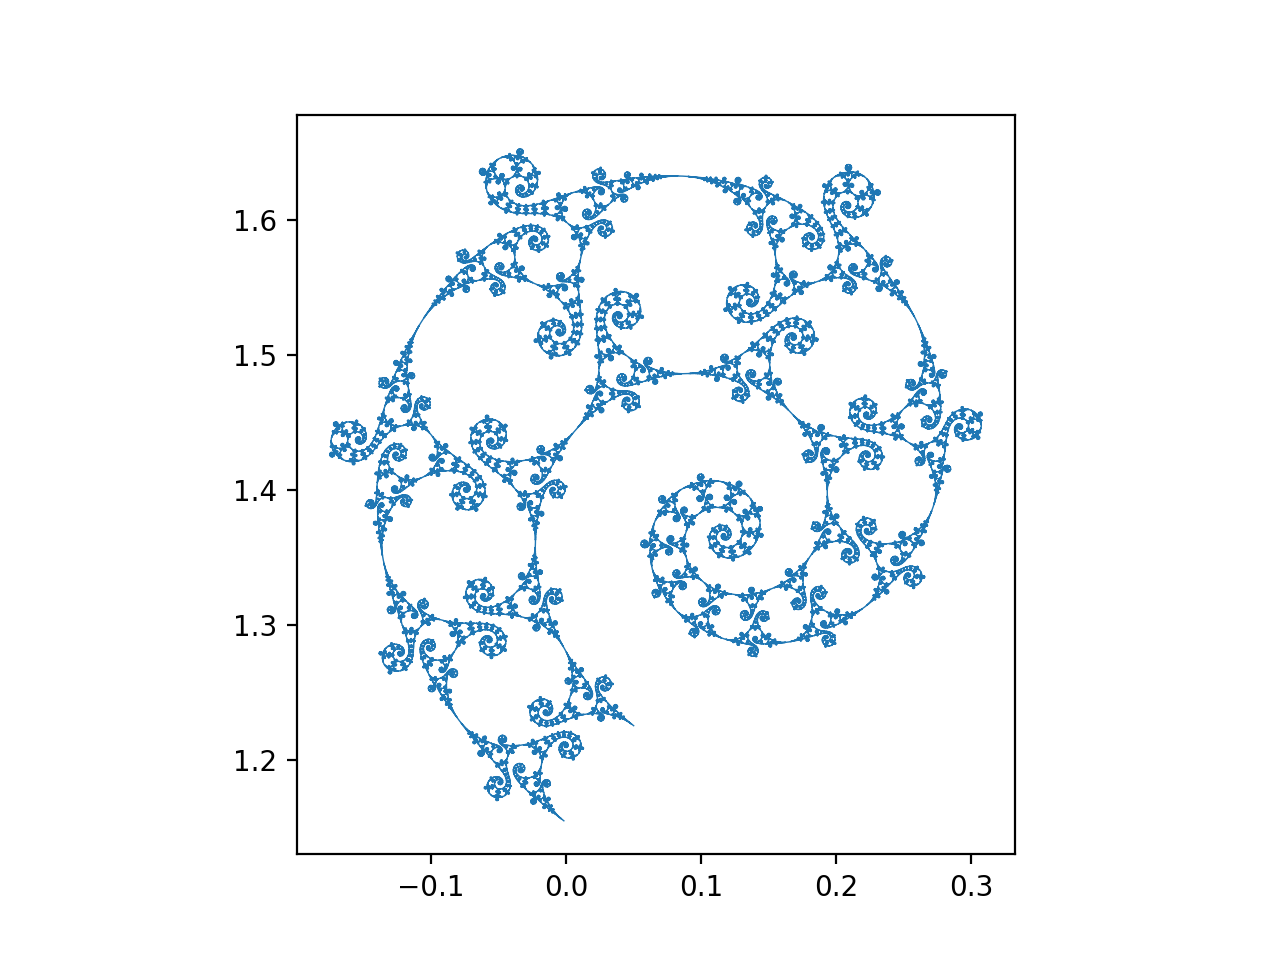

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
pts = list(range_dfs(gens, 'abbbbbb', 'abbbbbb'))
# NB. need to not connect to start point when plotting stretches...
ax.plot([x.real for x in pts], [x.imag for x in pts], linewidth=0.5)